
# <center> XAI (Explainable AI)</center>

<p> Build a TreeExplainer and compute Shaplay Values </p>
<p> ● Visualize explanations for a specific point of your data set, </p>
<p> ● Visualize explanations for all points of your data set at once, </p>
<p> ● Visualize a summary plot for each class on the whole dataset. </p>

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from xgboost.sklearn import XGBClassifier
from functools import partial

In [123]:
train = pd.read_csv("../data/raw/application_train.csv").set_index("SK_ID_CURR")
test = pd.read_csv("../data/raw/application_test.csv").set_index("SK_ID_CURR")
X = train.drop('TARGET',axis=1)#pd.concat([train, test], ignore_index=True).drop("TARGET", axis=1)
y = train.TARGET

In [122]:
test

NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
SK_ID_CURR                                                               
100001             Cash loans           F            N               Y   
100005             Cash loans           M            N               Y   
100013             Cash loans           M            Y               Y   
100028             Cash loans           F            N               Y   
100038             Cash loans           M            Y               N   
...                       ...         ...          ...             ...   
456221             Cash loans           F            N               Y   
456222             Cash loans           F            N               N   
456223             Cash loans           F            Y               Y   
456224             Cash loans           M            N               N   
456250             Cash loans           F            Y               N   

            CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
100001                 0          135000.0    568800.0      20560.5   
100005                 0           99000.0    222768.0      17370.0   
100013                 0          202500.0    663264.0      69777.0   
100028                 2          315000.0   1575000.0      49018.5   
100038                 1          180000.0    625500.0      32067.0   
...                  ...               ...         ...          ...   
456221                 0          121500.0    412560.0      17473.5   
456222                 2          157500.0    622413.0      31909.5   
456223                 1          202500.0    315000.0      33205.5   
456224                 0          225000.0    450000.0      25128.0   
456250                 0          135000.0    312768.0      24709.5   

            AMT_GOODS_PRICE NAME_TYPE_SUITE  ... FLAG_DOCUMENT_18  \
SK_ID_CURR                                   ...                    
100001             450000.0   Unaccompanied  ...                0   
100005             180000.0   Unaccompanied  ...                0   
100013             630000.0             NaN  ...                0   
100028            1575000.0   Unaccompanied  ...                0   
100038             625500.0   Unaccompanied  ...                0   
...                     ...             ...  ...              ...   
456221             270000.0   Unaccompanied  ...                0   
456222             495000.0   Unaccompanied  ...                0   
456223             315000.0   Unaccompanied  ...                0   
456224             450000.0          Family  ...                0   
456250             270000.0   Unaccompanied  ...                0   

           FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
SK_ID_CURR                                                      
100001                    0                0                0   
100005                    0                0                0   
100013                    0                0                0   
100028                    0                0                0   
100038                    0                0                0   
...                     ...              ...              ...   
456221                    0                0                0   
456222                    0                0                0   
456223                    0                0                0   
456224                    0                0                0   
456250                    0                0                0   

            AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
SK_ID_CURR                                                          
100001                             0.0                        0.0   
100005                             0.0                        0.0   
100013                             0.0                        0.0   
100028                             

In [65]:
# Some such as default would be binary features, but since
# they have a third class "unknown" we'll process them as non binary categorical
num_features = ["CNT_CHILDREN",	"AMT_INCOME_TOTAL",	"AMT_CREDIT",	"AMT_ANNUITY",	"AMT_GOODS_PRICE", "REGION_POPULATION_RELATIVE",	"DAYS_BIRTH",	"DAYS_EMPLOYED",
	"DAYS_REGISTRATION",	"DAYS_ID_PUBLISH",	"OWN_CAR_AGE",	"FLAG_MOBIL",	"FLAG_EMP_PHONE",	"FLAG_WORK_PHONE",	"FLAG_CONT_MOBILE",	"FLAG_PHONE",	"FLAG_EMAIL",
    "CNT_FAM_MEMBERS",	"REGION_RATING_CLIENT",	"REGION_RATING_CLIENT_W_CITY", "HOUR_APPR_PROCESS_START",	"REG_REGION_NOT_LIVE_REGION",	"REG_REGION_NOT_WORK_REGION",	
    "LIVE_REGION_NOT_WORK_REGION",	"REG_CITY_NOT_LIVE_CITY","REG_CITY_NOT_WORK_CITY",	"LIVE_CITY_NOT_WORK_CITY",
    "EXT_SOURCE_1",	"EXT_SOURCE_2",	"EXT_SOURCE_3",	"APARTMENTS_AVG",	"BASEMENTAREA_AVG",	"YEARS_BEGINEXPLUATATION_AVG",	"YEARS_BUILD_AVG",	
    "COMMONAREA_AVG",	"ELEVATORS_AVG",	"ENTRANCES_AVG",	"FLOORSMAX_AVG",	"FLOORSMIN_AVG",	"LANDAREA_AVG",	"LIVINGAPARTMENTS_AVG",	
    "LIVINGAREA_AVG",	"NONLIVINGAPARTMENTS_AVG",	"NONLIVINGAREA_AVG",	"APARTMENTS_MODE",	"BASEMENTAREA_MODE",	"YEARS_BEGINEXPLUATATION_MODE",	
    "YEARS_BUILD_MODE",	"COMMONAREA_MODE",	"ELEVATORS_MODE",	"ENTRANCES_MODE",	"FLOORSMAX_MODE",	"FLOORSMIN_MODE",	"LANDAREA_MODE",	
    "LIVINGAPARTMENTS_MODE",	"LIVINGAREA_MODE",	"NONLIVINGAPARTMENTS_MODE",	"NONLIVINGAREA_MODE",	"APARTMENTS_MEDI",	"BASEMENTAREA_MEDI",	
    "YEARS_BEGINEXPLUATATION_MEDI",	"YEARS_BUILD_MEDI",	"COMMONAREA_MEDI",
    "ELEVATORS_MEDI",	"ENTRANCES_MEDI",	"FLOORSMAX_MEDI",	"FLOORSMIN_MEDI",	"LANDAREA_MEDI",
    "LIVINGAPARTMENTS_MEDI",	"LIVINGAREA_MEDI",	"NONLIVINGAPARTMENTS_MEDI",	"NONLIVINGAREA_MEDI", "TOTALAREA_MODE",
    "OBS_30_CNT_SOCIAL_CIRCLE",	"DEF_30_CNT_SOCIAL_CIRCLE",	"OBS_60_CNT_SOCIAL_CIRCLE",	"DEF_60_CNT_SOCIAL_CIRCLE",	
    "DAYS_LAST_PHONE_CHANGE",	"FLAG_DOCUMENT_2",	"FLAG_DOCUMENT_3",	"FLAG_DOCUMENT_4",	"FLAG_DOCUMENT_5",	"FLAG_DOCUMENT_6",	
    "FLAG_DOCUMENT_7",	"FLAG_DOCUMENT_8",	"FLAG_DOCUMENT_9",	"FLAG_DOCUMENT_10",	"FLAG_DOCUMENT_11",	"FLAG_DOCUMENT_12",	
    "FLAG_DOCUMENT_13",	"FLAG_DOCUMENT_14",	"FLAG_DOCUMENT_15",	"FLAG_DOCUMENT_16",	"FLAG_DOCUMENT_17",	"FLAG_DOCUMENT_18",
    "FLAG_DOCUMENT_19",	"FLAG_DOCUMENT_20",	"FLAG_DOCUMENT_21",	"AMT_REQ_CREDIT_BUREAU_HOUR",	"AMT_REQ_CREDIT_BUREAU_DAY",
    "AMT_REQ_CREDIT_BUREAU_WEEK",	"AMT_REQ_CREDIT_BUREAU_MON",	"AMT_REQ_CREDIT_BUREAU_QRT",	"AMT_REQ_CREDIT_BUREAU_YEAR"	
	]

cat_features = ["NAME_CONTRACT_TYPE","CODE_GENDER", "NAME_TYPE_SUITE","NAME_INCOME_TYPE",
                    "NAME_EDUCATION_TYPE","NAME_FAMILY_STATUS","NAME_HOUSING_TYPE", "OCCUPATION_TYPE", 
                    "WEEKDAY_APPR_PROCESS_START","ORGANIZATION_TYPE", "FONDKAPREMONT_MODE", "HOUSETYPE_MODE",
                    "WALLSMATERIAL_MODE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "EMERGENCYSTATE_MODE"]

In [66]:
import sys
new_path = '../src/features'
if new_path not in sys.path:
    sys.path.append(new_path)
#import build_features
#preprocessor = build_features.data_prep(train,cat_features)

Process Nan...
TARGET - 0%
CNT_CHILDREN - 0%
AMT_INCOME_TOTAL - 0%
AMT_CREDIT - 0%
AMT_ANNUITY - 0%
AMT_GOODS_PRICE - 0%
REGION_POPULATION_RELATIVE - 0%
DAYS_BIRTH - 0%
DAYS_EMPLOYED - 0%
DAYS_REGISTRATION - 0%
DAYS_ID_PUBLISH - 0%
OWN_CAR_AGE - 66%
FLAG_MOBIL - 0%
FLAG_EMP_PHONE - 0%
FLAG_WORK_PHONE - 0%
FLAG_CONT_MOBILE - 0%
FLAG_PHONE - 0%
FLAG_EMAIL - 0%
CNT_FAM_MEMBERS - 0%
REGION_RATING_CLIENT - 0%
REGION_RATING_CLIENT_W_CITY - 0%
HOUR_APPR_PROCESS_START - 0%
REG_REGION_NOT_LIVE_REGION - 0%
REG_REGION_NOT_WORK_REGION - 0%
LIVE_REGION_NOT_WORK_REGION - 0%
REG_CITY_NOT_LIVE_CITY - 0%
REG_CITY_NOT_WORK_CITY - 0%
LIVE_CITY_NOT_WORK_CITY - 0%
EXT_SOURCE_1 - 56%
EXT_SOURCE_2 - 0%
EXT_SOURCE_3 - 20%
APARTMENTS_AVG - 51%
BASEMENTAREA_AVG - 59%
YEARS_BEGINEXPLUATATION_AVG - 49%
YEARS_BUILD_AVG - 66%
COMMONAREA_AVG - 70%
ELEVATORS_AVG - 53%
ENTRANCES_AVG - 50%
FLOORSMAX_AVG - 50%
FLOORSMIN_AVG - 68%
LANDAREA_AVG - 59%
LIVINGAPARTMENTS_AVG - 68%
LIVINGAREA_AVG - 50%
NONLIVINGAPARTMENTS_AVG 

In [167]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_transformer = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy = 'constant',
          fill_value = 'missing')),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)

numeric_transformer = Pipeline(
    [
        ('imputer_num', SimpleImputer(strategy = 'median')),
        ('scaler', StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    [
        ('categoricals', categorical_transformer, 
          cat_features),
        ('numericals', numeric_transformer, num_features)
    ],
    remainder = 'drop'
)

xgb_model = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('clf', XGBClassifier(scale_pos_weight=(1 - y.mean()), n_jobs=-1))
    ]
)

In [68]:
X_train, X_test = train.iloc[:, 1:240], test.iloc[:, 1:240]
y_train, y_test = train.TARGET, train.TARGET

In [156]:
ohe_categories = preprocessor.named_transformers_["categoricals"]#.categories_
ohe_categories

In [74]:
new_ohe_features = [f"{col}__{val}" for col, vals in zip(cat_features, ohe_categories) for val in vals]

In [75]:
all_features = num_features + new_ohe_features

In [163]:
i = 4
X_test.iloc[[i]]

CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                          
100038               M            Y               N             1   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
100038              180000.0    625500.0      32067.0         625500.0   

           NAME_TYPE_SUITE NAME_INCOME_TYPE  ... FLAG_DOCUMENT_18  \
SK_ID_CURR                                   ...                    
100038       Unaccompanied          Working  ...                0   

           FLAG_DOCUMENT_19 FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
SK_ID_CURR                                                       
100038                    0                0                 0   

            AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
SK_ID_CURR                                                          
100038                             NaN                        NaN   

            AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
SK_ID_CURR                                                          
100038                             NaN                        NaN   

            AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
SK_ID_CURR                                                         
100038                            NaN                         NaN  

[1 rows x 119 columns]

In [164]:
y_test.iloc[i]

0

In [192]:
from lime.lime_tabular import LimeTabularExplainer
gs = GridSearchCV(xgb_model, {"clf__max_depth": [5, 10],
                              "clf__min_child_weight": [5, 10],
                              "clf__n_estimators": [25]},
                  n_jobs=-1, cv=5, scoring="accuracy")

gs.fit(X_train, y_train)
print(gs.best_params_)
print(gs.best_score_)
xgb_model.set_params(**gs.best_params_)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X)
accuracy_score(y, y_pred)
print(classification_report(y, y_pred))

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('categoricals',
                                                                         Pipeline(steps=[('imputer_cat',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['NAME_CONTRACT_TYPE',
                                                                          'CODE_GENDER',
                                                                          'NAME_TYPE_SUITE',
                                                                          'NAME_INCOME_TYPE',
                                                                          'NAME_EDUCATION_TYPE',
                                                                          'NAME_...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [5, 10],
                         'clf__min_child_weight': [5, 10],
                         'clf__n_estimators': [25]},
             scoring='accuracy')

In [198]:
categorical_names = {}
for col in cat_features:
    categorical_names[X_train.columns.get_loc(col)] = [new_col.split("__")[1] 
                                                       for new_col in new_ohe_features 
                                                       if new_col.split("__")[0] == col]
categorical_names

In [200]:
def convert_to_lime_format(X, categorical_names, col_names=None, invert=False):
    if not isinstance(X, pd.DataFrame):
        X_lime = pd.DataFrame(X, columns=col_names)
    else:
        X_lime = X.copy()

    for k, v in categorical_names.items():
        if not invert:
            label_map = {
                str_label: int_label for int_label, str_label in enumerate(v)
            }
        else:
            label_map = {
                int_label: str_label for int_label, str_label in enumerate(v)
            }

        X_lime.iloc[:, k] = X_lime.iloc[:, k].map(label_map)
    return X_lime

In [201]:
convert_to_lime_format(X_train, categorical_names).head()

C:\Users\julie.ngan\AppData\Local\Temp\ipykernel_12736\3431962266.py:29: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_lime.iloc[:, k] = X_lime.iloc[:, k].map(label_map)
C:\Users\julie.ngan\AppData\Local\Temp\ipykernel_12736\3431962266.py:29: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_lime.iloc[:, k] = X_lime.iloc[:, k].map(label_map)
C:\Users\julie.ngan\AppData\Local\Temp\ipykernel_12736\3431962266.py:29: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array.

NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
SK_ID_CURR                                                                   
100002                       0            1             0                1   
100003                       0            0             0                0   
100004                       1            1             1                1   
100006                       0            0             0                1   
100007                       0            1             0                1   

            CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
100002                 0          202500.0    406597.5      24700.5   
100003                 0          270000.0   1293502.5      35698.5   
100004                 0           67500.0    135000.0       6750.0   
100006                 0          135000.0    312682.5      29686.5   
100007                 0          121500.0    513000.0      21865.5   

            AMT_GOODS_PRICE  NAME_TYPE_SUITE  ...  FLAG_DOCUMENT_18  \
SK_ID_CURR                                    ...                     
100002             351000.0              6.0  ...                 0   
100003            1129500.0              1.0  ...                 0   
100004             135000.0              6.0  ...                 0   
100006             297000.0              6.0  ...                 0   
100007             513000.0              6.0  ...                 0   

            FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
SK_ID_CURR                                                         
100002                     0                 0                 0   
100003                     0                 0                 0   
100004                     0                 0                 0   
100006                     0                 0                 0   
100007                     0                 0                 0   

            AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
SK_ID_CURR                                                          
100002                             0.0                        0.0   
100003                             0.0                        0.0   
100004                             0.0                        0.0   
100006                             NaN                        NaN   
100007                             0.0                        0.0   

            AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
SK_ID_CURR                                                          
100002                             0.0                        0.0   
100003                             0.0                        0.0   
100004                             0.0                        0.0   
100006                             NaN                        NaN   
100007                             0.0                        0.0   

            AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
SK_ID_CURR                                                         
100002                            0.0                         1.0  
100003                            0.0                         0.0  
100004                            0.0                         0.0  
100006                            NaN                         NaN  
100007                            0.0                         0.0  

[5 rows x 120 columns]

In [202]:
explainer = LimeTabularExplainer(convert_to_lime_format(X_train, categorical_names).values,
                                 mode="classification",
                                 feature_names=X_train.columns.tolist(),
                                 categorical_names=categorical_names,
                                 categorical_features=categorical_names.keys(),
                                 discretize_continuous=True,
                                 random_state=42)

C:\Users\julie.ngan\AppData\Local\Temp\ipykernel_12736\3431962266.py:29: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_lime.iloc[:, k] = X_lime.iloc[:, k].map(label_map)
C:\Users\julie.ngan\AppData\Local\Temp\ipykernel_12736\3431962266.py:29: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_lime.iloc[:, k] = X_lime.iloc[:, k].map(label_map)
C:\Users\julie.ngan\AppData\Local\Temp\ipykernel_12736\3431962266.py:29: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array.

In [1]:
i = 2
X_observation = X_test.iloc[[i], :]
X_observation

NameError: name 'X_test' is not defined

In [73]:
observation = convert_to_lime_format(X_test.iloc[[i], :],categorical_names).values[0]
observation

C:\Users\julie.ngan\AppData\Local\Temp\ipykernel_16956\3431962266.py:29: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_lime.iloc[:, k] = X_lime.iloc[:, k].map(label_map)
C:\Users\julie.ngan\AppData\Local\Temp\ipykernel_16956\3431962266.py:29: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_lime.iloc[:, k] = X_lime.iloc[:, k].map(label_map)
C:\Users\julie.ngan\AppData\Local\Temp\ipykernel_16956\3431962266.py:29: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array.

array([ 3.5000e+01,  9.0000e+00,  2.0000e+00,  5.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  1.0000e+00,  4.0000e+00,  0.0000e+00,
        1.0000e+00,  9.9900e+02,  0.0000e+00,  1.0000e+00,  1.4000e+00,
        9.4465e+01, -4.1800e+01,  4.9470e+00,  5.2281e+03])

In [ ]:
def predict_proba(X, model):
    X_str = convert_to_lime_format(X, categorical_names, col_names=X_train.columns, invert=True)
    return model.predict_proba(X_str)

In [75]:
xgb_predict_proba = partial(predict_proba, model=xgb_model)
explanation = explainer.explain_instance(observation, xgb_predict_proba, num_features=5)
explanation.show_in_notebook(show_table=True, show_all=False)

In [78]:
explanation.save_to_file("explanation.html")

In [79]:
print(explanation.local_exp)
print(explanation.intercept)
print(explanation.score)

{1: [(14, -0.3370625397423847), (17, 0.19458530462149298), (18, -0.18053443382803078), (15, 0.09880432604995228), (7, -0.06929534733372465)]}
{1: 0.6711143104846994}
0.41279908661112674


If your R-squared is low, the linear model that LIME fitted isn't a great approximation to your model, which means you should not rely too much on the explanation it provides.

## More local interpretation with SHAP

In [88]:
import shap
shap.initjs() 
explainer = shap.TreeExplainer(xgb_model.named_steps["clf"])
observations = xgb_model.named_steps["preprocessing"].transform(X_train.sample(1000, random_state=42))
shap_values = explainer.shap_values(observations)

In [93]:
i=0
shap.force_plot(explainer.expected_value, shap_values[i], 
                features=observations[i], feature_names=all_features)

In [94]:
shap.force_plot(explainer.expected_value, shap_values,
                features=observations, feature_names=all_features)

We can see our 1000 samples on the x axis. The y-axis corresponds to the same scale we were looking at before, where blue values corresponds to the probability decreasing, red increasing. Hover with your mouse on a point to see the main features impacting a given observation. You can also use the drop down on the left to visualise the impact of specific features, for example duration only.

Another interesting plot that we can generate with SHAP is the `summary_plot`, it can be seen as a feature importance plot with more meaningful insights. Below we're plotting the summary plot for class 1 on the whole subset.
The colour corresponds to the value of the feature and the x axis corresponds to the SHAP value, meaning the impact on the probability. 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


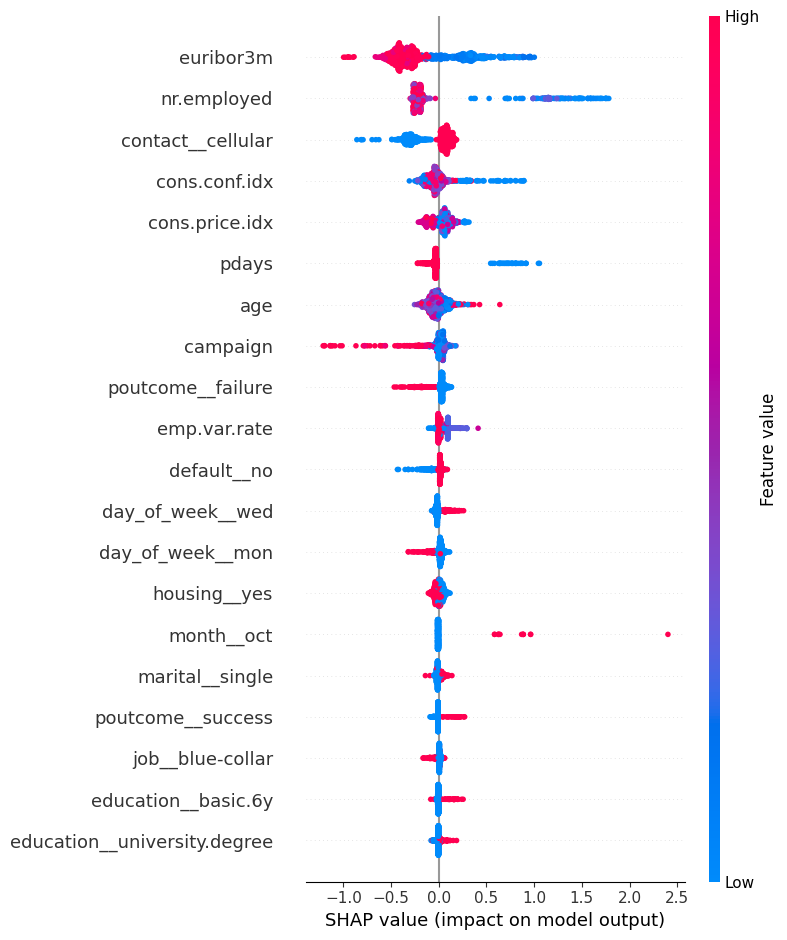

In [95]:
shap.summary_plot(shap_values, features=observations, feature_names=all_features)

That's better than the built-in feature importance on RandomForest because not only we can see what features are important but also how they affect our predictions.

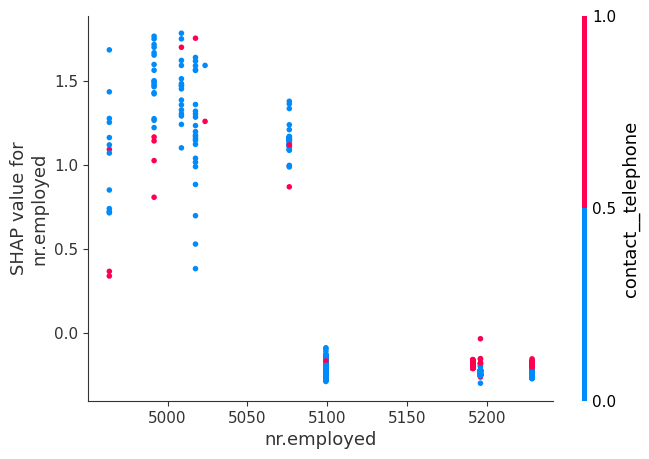

In [96]:
# Write here the code to visualise the dependance plot for "nr.employed"
shap.dependence_plot("nr.employed", shap_values, 
                     pd.DataFrame(observations, columns=all_features))